In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Bull phase LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
(248, 15, 4)
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
(219, 15, 4)
            previous_1d      EMA_12   willr

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

bull phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-10-07        17.00  19.847770 -84.169452 -28567700.0     2.0
2002-10-08        15.92  19.243497 -95.667449 -31364300.0     2.0
2002-10-09        17.40  18.959882 -77.411483 -28566500.0     2.0
2002-10-10        17.01  18.659901 -82.173381 -30113300.0     1.0
2002-10-11        15.57  18.184531 -92.376119 -34697400.0     2.0


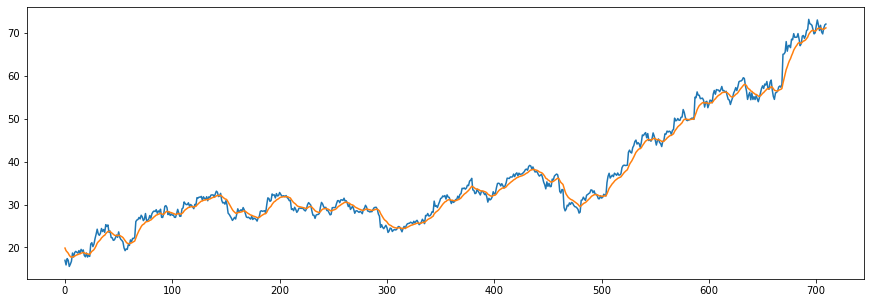

bull phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2012-05-29    70.000000  71.826248 -83.958021  76061900.0     2.0
2012-05-30    70.400002  71.606826 -76.058610  80035500.0     2.0
2012-05-31    69.389999  71.265775 -92.508157  75357900.0     2.0
2012-06-01    69.610001  71.011041 -86.872582  79549300.0     1.0
2012-06-04    67.239998  70.430880 -98.496264  73957300.0     2.0


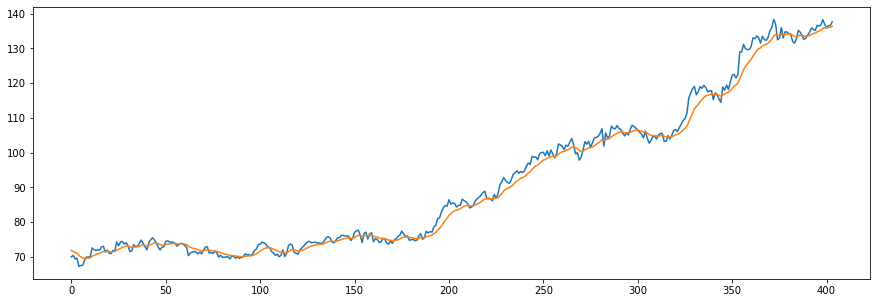

bull phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2015-09-21    17.299999  17.431825 -56.565680  1.278304e+10     2.0
2015-09-22    17.320000  17.414621 -55.892264  1.279559e+10     2.0
2015-09-23    17.389999  17.410833 -59.550566  1.281234e+10     2.0
2015-09-24    16.549999  17.278397 -94.921907  1.278454e+10     2.0
2015-09-25    16.600000  17.174028 -92.968737  1.279631e+10     2.0


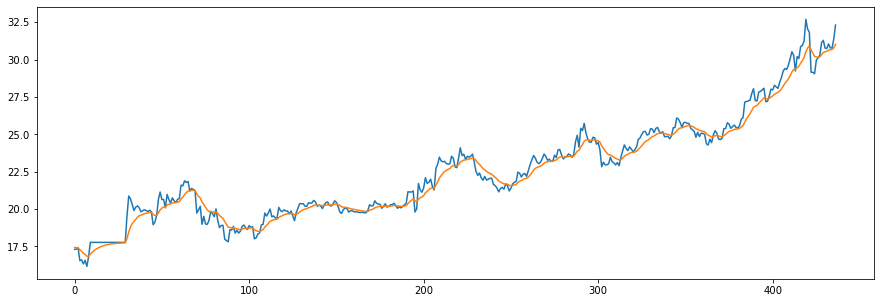

bull phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2016-08-01         8.60  8.822459 -95.454447  221939090.0     2.0
2016-08-02         8.66  8.797466 -81.818221  229749090.0     2.0
2016-08-03         8.59  8.765548 -91.489375  223312390.0     2.0
2016-08-04         8.35  8.701618 -93.055532  213631195.0     1.0
2016-08-05         8.31  8.641369 -95.945857  207289495.0     2.0


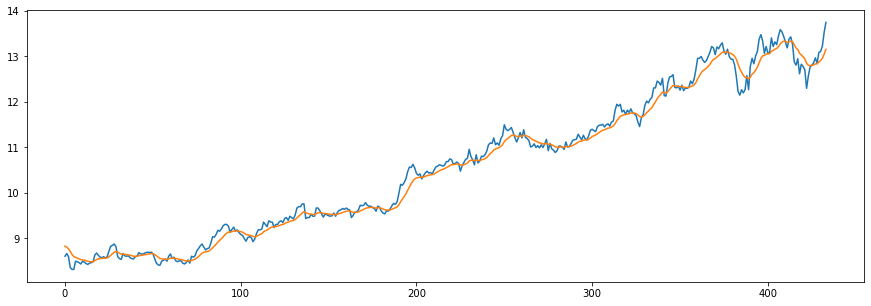

bull phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2012-05-29    33.500000  35.391902 -87.056352 -2.715978e+09     2.0
2012-05-30    33.630001  35.120840 -85.010916 -2.680123e+09     2.0
2012-05-31    32.959999  34.788403 -92.341351 -2.714327e+09     2.0
2012-06-01    33.150002  34.536341 -84.467667 -2.672202e+09     2.0
2012-06-04    31.930000  34.135366 -97.090912 -2.722674e+09     1.0


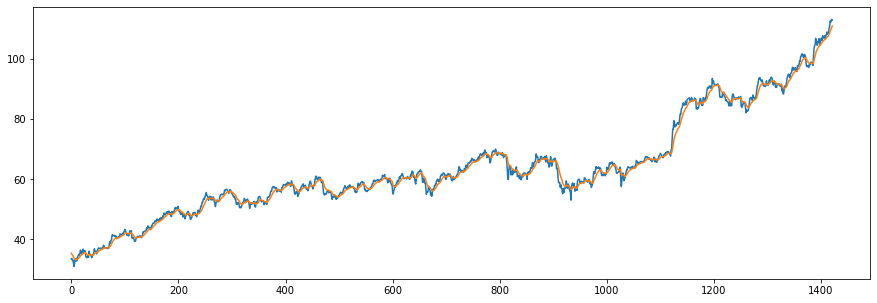

bull phase data\5_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


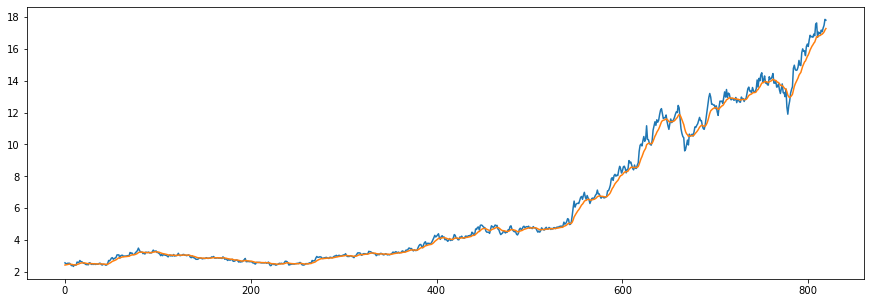

In [9]:
labels = []
sequential = []

for filepath in glob.iglob('bull phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [10]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4143, 15, 4)

In [11]:
y = labels
y = np.array(y)
y.shape

(4143,)

In [12]:
from collections import Counter

Counter(y)

Counter({0.0: 185, 2.0: 3780, 1.0: 178})

In [13]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [14]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/26 [>.............................] - ETA: 0s - loss: 0.3592 - accuracy: 0.4922 - mse: 0.3434 - weighted_accuracy: 0.2564 - weighted_mse: 0.5352WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 44ms/step - loss: 0.3018 - accuracy: 0.5039 - mse: 0.4321 - weighted_accuracy: 0.3036 - weighted_mse: 0.5075 - val_loss: 0.3003 - val_accuracy: 0.0422 - val_mse: 0.3517 - val_weighted_accuracy: 0.0422 - val_weighted_mse: 0.3517
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2194 - accuracy: 0.3793 - mse: 0.7018 - weighted_accuracy: 0.4177 - weighted_mse: 0.6985 - val_loss: 0.2919 - val_accuracy: 0.0434 - val_mse: 0.3745 - val_weighted_accuracy: 0.04

7/7 [==============================] - 0s 3ms/step - loss: 0.1725 - accuracy: 0.5616 - mse: 1.2847 - weighted_accuracy: 0.5616 - weighted_mse: 1.2847
Test loss: 0.1725437045097351
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 48
actual holds but predicted sell: 39
actual predicted holds: 114
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 93.44262295081967%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.88524590163935%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Price increase from

9/9 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.4676 - mse: 1.3330 - weighted_accuracy: 0.4676 - weighted_mse: 1.3330
Test loss: 0.18135367333889008
Test accuracy: 0.4676258862018585


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 8
actual holds but predicted buy: 99
actual holds but predicted sell: 34
actual predicted holds: 116
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 12.5%
Percentage holds correct: 89.23076923076923%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.598130841121495%
Percentage high sells correct: 42.5%
Percentage mid holds correct: 83.07692307692308%


Capital: 100
Share price: $0.8232401149455993
Shares owned at the moment: 121
Cash capital at the moment: $0.11401294333433043


Price increase from previousl

19/19 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.5126 - mse: 1.3284 - weighted_accuracy: 0.5126 - weighted_mse: 1.3284
Test loss: 0.18097488582134247
Test accuracy: 0.5126050710678101


number of predictions: 595
actual predicted buys: 16
actual buys but predicted sell: 6
actual buys but predicted hold: 10
actual sells but predicted buy: 3
actual predicted sells: 12
actual sells but predicted hold: 12
actual holds but predicted buy: 145
actual holds but predicted sell: 114
actual predicted holds: 277
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 92.64214046822742%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 43.90243902439025%
Percentage high sells correct: 44.696969696969695%
Percentage mid holds correct: 84.56375838926175%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867

29/29 [==============================] - 0s 3ms/step - loss: 0.1816 - accuracy: 0.5038 - mse: 1.3471 - weighted_accuracy: 0.5038 - weighted_mse: 1.3471
Test loss: 0.18159031867980957
Test accuracy: 0.5038167834281921


number of predictions: 917
actual predicted buys: 25
actual buys but predicted sell: 3
actual buys but predicted hold: 18
actual sells but predicted buy: 7
actual predicted sells: 11
actual sells but predicted hold: 22
actual holds but predicted buy: 252
actual holds but predicted sell: 153
actual predicted holds: 426
Percentage buys correct: 8.80281690140845%
Percentage sells correct: 6.586826347305389%
Percentage holds correct: 91.41630901287553%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 50.17667844522968%
Percentage high sells correct: 47.90419161676647%
Percentage mid holds correct: 83.2618025751073%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656




6         -96.006693  



RUNNING EPOCHS 20 - 40



Epoch 1/20
26/26 [==============================] - 1s 52ms/step - loss: 0.1435 - accuracy: 0.3811 - mse: 1.4966 - weighted_accuracy: 0.6869 - weighted_mse: 1.4233 - val_loss: 0.1757 - val_accuracy: 0.4970 - val_mse: 1.3109 - val_weighted_accuracy: 0.4970 - val_weighted_mse: 1.3109
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1437 - accuracy: 0.4225 - mse: 1.4800 - weighted_accuracy: 0.6913 - weighted_mse: 1.4105 - val_loss: 0.1743 - val_accuracy: 0.5115 - val_mse: 1.3528 - val_weighted_accuracy: 0.5115 - val_weighted_mse: 1.3528
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1412 - accuracy: 0.4309 - mse: 1.4981 - weighted_accuracy: 0.6878 - weighted_mse: 1.4346 - val_loss: 0.1829 - val_accuracy: 0.4294 - val_mse: 1.3401 - val_weighted_accuracy: 0.4294 - val_weighted_mse: 1.3401
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.4403 - m

7/7 [==============================] - 0s 2ms/step - loss: 0.1840 - accuracy: 0.5160 - mse: 1.7117 - weighted_accuracy: 0.5160 - weighted_mse: 1.7117
Test loss: 0.18397141993045807
Test accuracy: 0.5159817337989807


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 44
actual predicted holds: 100
Percentage buys correct: 9.375%
Percentage sells correct: 13.72549019607843%
Percentage holds correct: 96.15384615384616%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 54.90196078431372%
Percentage mid holds correct: 86.53846153846153%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fr

9/9 [==============================] - 0s 3ms/step - loss: 0.2001 - accuracy: 0.3849 - mse: 1.8414 - weighted_accuracy: 0.3849 - weighted_mse: 1.8414
Test loss: 0.20005548000335693
Test accuracy: 0.384892076253891


number of predictions: 278
actual predicted buys: 12
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 120
actual holds but predicted sell: 37
actual predicted holds: 92
Percentage buys correct: 8.955223880597014%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 89.32038834951456%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.1203007518797%
Percentage high sells correct: 43.90243902439025%
Percentage mid holds correct: 84.46601941747574%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price 

19/19 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.3748 - mse: 1.8722 - weighted_accuracy: 0.3748 - weighted_mse: 1.8722
Test loss: 0.21216215193271637
Test accuracy: 0.37478992342948914


number of predictions: 595
actual predicted buys: 22
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 7
actual predicted sells: 10
actual sells but predicted hold: 10
actual holds but predicted buy: 207
actual holds but predicted sell: 138
actual predicted holds: 191
Percentage buys correct: 9.322033898305085%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 91.38755980861244%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.212765957446805%
Percentage high sells correct: 52.666666666666664%
Percentage mid holds correct: 82.77511961722487%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.13444977041808

5         -91.884658  


full cycle data


29/29 [==============================] - 0s 3ms/step - loss: 0.2114 - accuracy: 0.3926 - mse: 1.8657 - weighted_accuracy: 0.3926 - weighted_mse: 1.8657
Test loss: 0.2114015370607376
Test accuracy: 0.39258450269699097


number of predictions: 917
actual predicted buys: 34
actual buys but predicted sell: 6
actual buys but predicted hold: 6
actual sells but predicted buy: 6
actual predicted sells: 18
actual sells but predicted hold: 16
actual holds but predicted buy: 347
actual holds but predicted sell: 176
actual predicted holds: 308
Percentage buys correct: 8.785529715762275%
Percentage sells correct: 9.0%
Percentage holds correct: 93.33333333333333%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 48.96373056994819%
Percentage high sells correct: 49.5%
Percentage mid holds correct: 86.06060606060606%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.




RUNNING EPOCHS 40 - 60



Epoch 1/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1217 - accuracy: 0.5054 - mse: 1.8130 - weighted_accuracy: 0.7626 - weighted_mse: 1.7747 - val_loss: 0.1818 - val_accuracy: 0.4548 - val_mse: 1.8322 - val_weighted_accuracy: 0.4548 - val_weighted_mse: 1.8322
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1219 - accuracy: 0.5290 - mse: 1.8108 - weighted_accuracy: 0.7757 - weighted_mse: 1.7580 - val_loss: 0.1879 - val_accuracy: 0.4511 - val_mse: 1.9173 - val_weighted_accuracy: 0.4511 - val_weighted_mse: 1.9173
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1192 - accuracy: 0.5549 - mse: 1.8188 - weighted_accuracy: 0.7895 - weighted_mse: 1.7877 - val_loss: 0.1921 - val_accuracy: 0.4186 - val_mse: 1.8639 - val_weighted_accuracy: 0.4186 - val_weighted_mse: 1.8639
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1193 - accuracy: 0.5510 - mse: 1.8405 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.6164 - mse: 2.2002 - weighted_accuracy: 0.6164 - weighted_mse: 2.2002
Test loss: 0.16333147883415222
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 47
actual holds but predicted sell: 32
actual predicted holds: 122
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 20.0%
Percentage holds correct: 96.06299212598425%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.94117647058823%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 88.18897637795276%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously 

9/9 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.5108 - mse: 2.4034 - weighted_accuracy: 0.5108 - weighted_mse: 2.4034
Test loss: 0.1783875972032547
Test accuracy: 0.5107913613319397


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 85
actual holds but predicted sell: 33
actual predicted holds: 131
Percentage buys correct: 9.473684210526315%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 89.1156462585034%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.93617021276596%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 84.35374149659864%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price

19/19 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.4555 - mse: 2.3906 - weighted_accuracy: 0.4555 - weighted_mse: 2.3906
Test loss: 0.20147904753684998
Test accuracy: 0.45546218752861023


number of predictions: 595
actual predicted buys: 19
actual buys but predicted sell: 2
actual buys but predicted hold: 11
actual sells but predicted buy: 4
actual predicted sells: 11
actual sells but predicted hold: 12
actual holds but predicted buy: 166
actual holds but predicted sell: 129
actual predicted holds: 241
Percentage buys correct: 10.052910052910052%
Percentage sells correct: 7.746478873239437%
Percentage holds correct: 91.28787878787878%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 52.659574468085104%
Percentage high sells correct: 54.225352112676056%
Percentage mid holds correct: 82.57575757575758%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.134449770418

29/29 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.4842 - mse: 2.3760 - weighted_accuracy: 0.4842 - weighted_mse: 2.3760
Test loss: 0.19592604041099548
Test accuracy: 0.4841875731945038


number of predictions: 917
actual predicted buys: 28
actual buys but predicted sell: 7
actual buys but predicted hold: 11
actual sells but predicted buy: 6
actual predicted sells: 15
actual sells but predicted hold: 19
actual holds but predicted buy: 284
actual holds but predicted sell: 146
actual predicted holds: 401
Percentage buys correct: 8.80503144654088%
Percentage sells correct: 8.928571428571429%
Percentage holds correct: 93.03944315545243%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 48.58044164037855%
Percentage high sells correct: 48.214285714285715%
Percentage mid holds correct: 86.07888631090488%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985684

Epoch 1/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1029 - accuracy: 0.6171 - mse: 2.2013 - weighted_accuracy: 0.8338 - weighted_mse: 2.2095 - val_loss: 0.1748 - val_accuracy: 0.5356 - val_mse: 2.3282 - val_weighted_accuracy: 0.5356 - val_weighted_mse: 2.3282
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1036 - accuracy: 0.6195 - mse: 2.2110 - weighted_accuracy: 0.8330 - weighted_mse: 2.1876 - val_loss: 0.1837 - val_accuracy: 0.4994 - val_mse: 2.4740 - val_weighted_accuracy: 0.4994 - val_weighted_mse: 2.4740
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1004 - accuracy: 0.6427 - mse: 2.2163 - weighted_accuracy: 0.8390 - weighted_mse: 2.2292 - val_loss: 0.1822 - val_accuracy: 0.4994 - val_mse: 2.3039 - val_weighted_accuracy: 0.4994 - val_weighted_mse: 2.3039
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.6439 - mse: 2.2562 - weighted_accuracy: 0.8484 - weighted_ms

7/7 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.6712 - mse: 2.9092 - weighted_accuracy: 0.6712 - weighted_mse: 2.9092
Test loss: 0.14958997070789337
Test accuracy: 0.6712328791618347


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 40
actual holds but predicted sell: 27
actual predicted holds: 134
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 22.857142857142858%
Percentage holds correct: 96.40287769784173%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.81818181818182%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.76978417266187%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fr

9/9 [==============================] - 0s 4ms/step - loss: 0.1677 - accuracy: 0.5935 - mse: 3.1326 - weighted_accuracy: 0.5935 - weighted_mse: 3.1326
Test loss: 0.16773857176303864
Test accuracy: 0.5935251712799072


number of predictions: 278
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 11
actual holds but predicted buy: 66
actual holds but predicted sell: 25
actual predicted holds: 158
Percentage buys correct: 7.042253521126761%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 88.26815642458101%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 52.857142857142854%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.79888268156425%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price increase

19/19 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.5261 - mse: 3.0529 - weighted_accuracy: 0.5261 - weighted_mse: 3.0529
Test loss: 0.19754591584205627
Test accuracy: 0.5260504484176636


number of predictions: 595
actual predicted buys: 12
actual buys but predicted sell: 4
actual buys but predicted hold: 16
actual sells but predicted buy: 4
actual predicted sells: 12
actual sells but predicted hold: 11
actual holds but predicted buy: 132
actual holds but predicted sell: 115
actual predicted holds: 289
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 9.16030534351145%
Percentage holds correct: 91.45569620253164%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 47.2972972972973%
Percentage high sells correct: 56.48854961832061%
Percentage mid holds correct: 82.22222222222223%


Capital: 100
Share price: $0.9426119558767306
Shares owned at the moment: 105
Cash capital at the moment: $0.7535654306838779



29/29 [==============================] - 0s 4ms/step - loss: 0.1860 - accuracy: 0.5605 - mse: 3.0251 - weighted_accuracy: 0.5605 - weighted_mse: 3.0251
Test loss: 0.18595369160175323
Test accuracy: 0.5605234503746033


number of predictions: 917
actual predicted buys: 24
actual buys but predicted sell: 5
actual buys but predicted hold: 17
actual sells but predicted buy: 4
actual predicted sells: 14
actual sells but predicted hold: 22
actual holds but predicted buy: 238
actual holds but predicted sell: 117
actual predicted holds: 476
Percentage buys correct: 9.022556390977444%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 92.42718446601941%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.320754716981135%
Percentage high sells correct: 48.529411764705884%
Percentage mid holds correct: 86.01941747572816%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985

Price increase from previously bought: -33.88570147185235%
Share price: $0.22356556657146986
Shares owned at the moment: 0
Cash capital at the moment: $18.201676735280802


Share price: $0.16948668372178943
Shares owned at the moment: 107
Cash capital at the moment: $0.01673012036419763


Price increase from previously bought: 10.512180978683606%
Share price: $0.18781851508367886
Shares owned at the moment: 0
Cash capital at the moment: $20.058045636254466


Share price: $0.18965165014279528
Shares owned at the moment: 105
Cash capital at the moment: $0.08986045728222791


Price increase from previously bought: -1.2381750918772472%
Share price: $0.18781851508367886
Shares owned at the moment: 0
Cash capital at the moment: $19.756571944838093


Share price: $0.17131986248733566
Shares owned at the moment: 115
Cash capital at the moment: $0.000607852282872301


Price increase from previously bought: 35.473585567784525%
Share price: $0.2327314166927703
Shares owned at the moment: 0
Cash c

26/26 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.7474 - mse: 3.1450 - weighted_accuracy: 0.8926 - weighted_mse: 3.1501 - val_loss: 0.1868 - val_accuracy: 0.5862 - val_mse: 3.3262 - val_weighted_accuracy: 0.5862 - val_weighted_mse: 3.3262
Epoch 15/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0758 - accuracy: 0.7417 - mse: 3.1937 - weighted_accuracy: 0.8969 - weighted_mse: 3.2416 - val_loss: 0.2037 - val_accuracy: 0.5332 - val_mse: 3.5657 - val_weighted_accuracy: 0.5332 - val_weighted_mse: 3.5657
Epoch 16/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0740 - accuracy: 0.7580 - mse: 3.2128 - weighted_accuracy: 0.9029 - weighted_mse: 3.2607 - val_loss: 0.1979 - val_accuracy: 0.5356 - val_mse: 3.4287 - val_weighted_accuracy: 0.5356 - val_weighted_mse: 3.4287
Epoch 17/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0707 - accuracy: 0.7625 - mse: 3.2438 - weighted_accuracy: 0.9110 - weighted_mse: 3.2858

15/15 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.5553 - mse: 3.7348 - weighted_accuracy: 0.5553 - weighted_mse: 3.7348
Test loss: 0.20752696692943573
Test accuracy: 0.5553191304206848


number of predictions: 470
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 16
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 15
actual holds but predicted buy: 101
actual holds but predicted sell: 75
actual predicted holds: 250
Percentage buys correct: 5.607476635514018%
Percentage sells correct: 6.097560975609756%
Percentage holds correct: 88.96797153024912%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 53.271028037383175%
Percentage high sells correct: 51.21951219512195%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.5051713785101153
Shares owned at the moment: 197
Cash capital at the moment: $0.20756183919942828


7/7 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.5385 - mse: 3.3405 - weighted_accuracy: 0.5385 - weighted_mse: 3.3405
Test loss: 0.18451420962810516
Test accuracy: 0.5384615659713745


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 26
actual holds but predicted sell: 56
actual predicted holds: 107
Percentage buys correct: 10.0%
Percentage sells correct: 3.4482758620689653%
Percentage holds correct: 89.16666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 44.827586206896555%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.1503089080399258
Shares owned at the moment: 663
Cash capital at the moment: $0.07114325294539015


Price increase f

29/29 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.6292 - mse: 3.7228 - weighted_accuracy: 0.6292 - weighted_mse: 3.7228
Test loss: 0.18108858168125153
Test accuracy: 0.6292257308959961


number of predictions: 917
actual predicted buys: 21
actual buys but predicted sell: 4
actual buys but predicted hold: 21
actual sells but predicted buy: 5
actual predicted sells: 12
actual sells but predicted hold: 23
actual holds but predicted buy: 194
actual holds but predicted sell: 93
actual predicted holds: 544
Percentage buys correct: 9.545454545454545%
Percentage sells correct: 11.009174311926605%
Percentage holds correct: 92.51700680272108%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.141552511415526%
Percentage high sells correct: 52.293577981651374%
Percentage mid holds correct: 85.37414965986395%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.1432366899856




RUNNING EPOCHS 100 - 120



Epoch 1/20
26/26 [==============================] - 0s 17ms/step - loss: 0.0684 - accuracy: 0.7849 - mse: 3.4091 - weighted_accuracy: 0.9106 - weighted_mse: 3.4392 - val_loss: 0.1818 - val_accuracy: 0.6007 - val_mse: 3.7102 - val_weighted_accuracy: 0.6007 - val_weighted_mse: 3.7102
Epoch 2/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0697 - accuracy: 0.7710 - mse: 3.4231 - weighted_accuracy: 0.9098 - weighted_mse: 3.4087 - val_loss: 0.1784 - val_accuracy: 0.6297 - val_mse: 3.7646 - val_weighted_accuracy: 0.6297 - val_weighted_mse: 3.7646
Epoch 3/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0674 - accuracy: 0.7945 - mse: 3.4707 - weighted_accuracy: 0.9206 - weighted_mse: 3.4903 - val_loss: 0.1742 - val_accuracy: 0.6478 - val_mse: 3.7152 - val_weighted_accuracy: 0.6478 - val_weighted_mse: 3.7152
Epoch 4/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0673 - accuracy: 0.7918 - mse: 3.5258 - weigh

7/7 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.7808 - mse: 4.9030 - weighted_accuracy: 0.7808 - weighted_mse: 4.9030
Test loss: 0.1227518692612648
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 24
actual holds but predicted sell: 12
actual predicted holds: 165
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 93.22033898305085%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 85.87570621468926%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


P

9/9 [==============================] - 0s 3ms/step - loss: 0.1627 - accuracy: 0.6978 - mse: 5.3913 - weighted_accuracy: 0.6978 - weighted_mse: 5.3913
Test loss: 0.1626581847667694
Test accuracy: 0.6978417038917542


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 11
actual holds but predicted buy: 44
actual holds but predicted sell: 17
actual predicted holds: 188
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.0%
Percentage holds correct: 89.52380952380952%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price increase from previous

19/19 [==============================] - 0s 3ms/step - loss: 0.1844 - accuracy: 0.6454 - mse: 4.7150 - weighted_accuracy: 0.6454 - weighted_mse: 4.7150
Test loss: 0.18443062901496887
Test accuracy: 0.6453781723976135


number of predictions: 595
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 22
actual sells but predicted buy: 4
actual predicted sells: 10
actual sells but predicted hold: 13
actual holds but predicted buy: 90
actual holds but predicted sell: 79
actual predicted holds: 367
Percentage buys correct: 6.930693069306931%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 91.29353233830845%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 47.524752475247524%
Percentage high sells correct: 55.43478260869565%
Percentage mid holds correct: 83.79052369077307%


Capital: 100
Share price: $0.9426119558767306
Shares owned at the moment: 105
Cash capital at the moment: $0.7535654306838779


29/29 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.7045 - mse: 4.7832 - weighted_accuracy: 0.7045 - weighted_mse: 4.7832
Test loss: 0.17153328657150269
Test accuracy: 0.7044711112976074


number of predictions: 917
actual predicted buys: 18
actual buys but predicted sell: 1
actual buys but predicted hold: 27
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 28
actual holds but predicted buy: 147
actual holds but predicted sell: 64
actual predicted holds: 620
Percentage buys correct: 10.650887573964496%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 91.85185185185185%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 47.945205479452056%
Percentage mid holds correct: 84.88888888888889%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985684

Epoch 1/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0540 - accuracy: 0.8431 - mse: 4.3283 - weighted_accuracy: 0.9383 - weighted_mse: 4.2383 - val_loss: 0.1820 - val_accuracy: 0.6767 - val_mse: 4.6814 - val_weighted_accuracy: 0.6767 - val_weighted_mse: 4.6814
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0552 - accuracy: 0.8313 - mse: 4.3426 - weighted_accuracy: 0.9361 - weighted_mse: 4.2099 - val_loss: 0.1880 - val_accuracy: 0.6707 - val_mse: 4.6736 - val_weighted_accuracy: 0.6707 - val_weighted_mse: 4.6736
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0530 - accuracy: 0.8467 - mse: 4.4121 - weighted_accuracy: 0.9418 - weighted_mse: 4.2983 - val_loss: 0.1750 - val_accuracy: 0.7057 - val_mse: 4.8072 - val_weighted_accuracy: 0.7057 - val_weighted_mse: 4.8072
Epoch 4/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0531 - accuracy: 0.8434 - mse: 4.4844 - weighted_accuracy: 0.9406 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1236 - accuracy: 0.8128 - mse: 6.2341 - weighted_accuracy: 0.8128 - weighted_mse: 6.2341
Test loss: 0.12358535081148148
Test accuracy: 0.8127853870391846


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 10
actual predicted holds: 175
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 92.10526315789474%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 70.58823529411765%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 85.26315789473684%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Pr

9/9 [==============================] - 0s 4ms/step - loss: 0.1706 - accuracy: 0.7662 - mse: 6.6806 - weighted_accuracy: 0.7662 - weighted_mse: 6.6806
Test loss: 0.17064672708511353
Test accuracy: 0.7661870718002319


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 31
actual holds but predicted sell: 10
actual predicted holds: 208
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.04329004329004%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 83.91304347826087%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594



29/29 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.7405 - mse: 5.8148 - weighted_accuracy: 0.7405 - weighted_mse: 5.8148
Test loss: 0.17357856035232544
Test accuracy: 0.7404580116271973


number of predictions: 917
actual predicted buys: 18
actual buys but predicted sell: 1
actual buys but predicted hold: 27
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 33
actual holds but predicted buy: 124
actual holds but predicted sell: 50
actual predicted holds: 657
Percentage buys correct: 12.413793103448276%
Percentage sells correct: 7.2727272727272725%
Percentage holds correct: 91.63179916317992%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.793103448275865%
Percentage high sells correct: 50.90909090909091%
Percentage mid holds correct: 84.91620111731844%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.14323668998568

26/26 [==============================] - 0s 14ms/step - loss: 0.0427 - accuracy: 0.8847 - mse: 5.4717 - weighted_accuracy: 0.9557 - weighted_mse: 5.1581 - val_loss: 0.1910 - val_accuracy: 0.7105 - val_mse: 5.8458 - val_weighted_accuracy: 0.7105 - val_weighted_mse: 5.8458
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.8778 - mse: 5.4787 - weighted_accuracy: 0.9554 - weighted_mse: 5.1264 - val_loss: 0.1998 - val_accuracy: 0.6996 - val_mse: 5.7501 - val_weighted_accuracy: 0.6996 - val_weighted_mse: 5.7501
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0415 - accuracy: 0.8887 - mse: 5.5822 - weighted_accuracy: 0.9593 - weighted_mse: 5.2280 - val_loss: 0.1880 - val_accuracy: 0.7527 - val_mse: 6.1253 - val_weighted_accuracy: 0.7527 - val_weighted_mse: 6.1253
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0414 - accuracy: 0.8835 - mse: 5.6194 - weighted_accuracy: 0.9552 - weighted_mse: 5.2629 

7/7 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.8438 - mse: 9.3374 - weighted_accuracy: 0.8438 - weighted_mse: 9.337 - 0s 4ms/step - loss: 0.1339 - accuracy: 0.8311 - mse: 7.7760 - weighted_accuracy: 0.8311 - weighted_mse: 7.7760
Test loss: 0.1338789463043213
Test accuracy: 0.8310502171516418


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 15
actual holds but predicted sell: 8
actual predicted holds: 178
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 20.0%
Percentage holds correct: 92.70833333333333%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 75.0%
Percentage high sells correct: 70.0%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the

9/9 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.7698 - mse: 8.1567 - weighted_accuracy: 0.7698 - weighted_mse: 8.1567
Test loss: 0.18842075765132904
Test accuracy: 0.769784152507782


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 32
actual holds but predicted sell: 8
actual predicted holds: 209
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 89.69957081545064%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 84.05172413793103%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Pri

29/29 [==============================] - 0s 4ms/step - loss: 0.1897 - accuracy: 0.7546 - mse: 7.0708 - weighted_accuracy: 0.7546 - weighted_mse: 7.0708
Test loss: 0.1896522343158722
Test accuracy: 0.7546346783638


number of predictions: 917
actual predicted buys: 17
actual buys but predicted sell: 1
actual buys but predicted hold: 28
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 34
actual holds but predicted buy: 110
actual holds but predicted sell: 49
actual predicted holds: 672
Percentage buys correct: 13.076923076923077%
Percentage sells correct: 5.660377358490566%
Percentage holds correct: 91.55313351498637%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.07692307692308%
Percentage high sells correct: 49.056603773584904%
Percentage mid holds correct: 84.72032742155525%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.1432366899856845




26/26 [==============================] - 0s 13ms/step - loss: 0.0338 - accuracy: 0.9158 - mse: 6.8052 - weighted_accuracy: 0.9670 - weighted_mse: 6.1788 - val_loss: 0.2071 - val_accuracy: 0.7419 - val_mse: 7.1647 - val_weighted_accuracy: 0.7419 - val_weighted_mse: 7.1647
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0345 - accuracy: 0.9065 - mse: 6.7753 - weighted_accuracy: 0.9658 - weighted_mse: 6.1105 - val_loss: 0.2165 - val_accuracy: 0.7322 - val_mse: 6.9257 - val_weighted_accuracy: 0.7322 - val_weighted_mse: 6.9257
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0327 - accuracy: 0.9206 - mse: 6.9641 - weighted_accuracy: 0.9688 - weighted_mse: 6.2481 - val_loss: 0.2060 - val_accuracy: 0.7600 - val_mse: 7.5109 - val_weighted_accuracy: 0.7600 - val_weighted_mse: 7.5109
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0323 - accuracy: 0.9146 - mse: 6.9836 - weighted_accuracy: 0.9666 - weighted_mse: 6.3120

7/7 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.8402 - mse: 9.5815 - weighted_accuracy: 0.8402 - weighted_mse: 9.5815
Test loss: 0.14223025739192963
Test accuracy: 0.8401826620101929


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 12
actual holds but predicted sell: 7
actual predicted holds: 182
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 91.91919191919192%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 76.92307692307692%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase 

9/9 [==============================] - 0s 4ms/step - loss: 0.2040 - accuracy: 0.7842 - mse: 9.4167 - weighted_accuracy: 0.7842 - weighted_mse: 9.4167
Test loss: 0.2039601355791092
Test accuracy: 0.7841726541519165


number of predictions: 278
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 16
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 13
actual holds but predicted buy: 23
actual holds but predicted sell: 8
actual predicted holds: 218
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.25910931174089%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 39.130434782608695%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 82.11382113821138%


Capital: 100
Share price: $0.8567231571051698
Shares owned at the moment: 116
Cash capital at the moment: $0.346819088683759


Price increase from previously bought: -31.650

29/29 [==============================] - 0s 4ms/step - loss: 0.1983 - accuracy: 0.7797 - mse: 8.2955 - weighted_accuracy: 0.7797 - weighted_mse: 8.2955
Test loss: 0.1982525885105133
Test accuracy: 0.7797164916992188


number of predictions: 917
actual predicted buys: 16
actual buys but predicted sell: 1
actual buys but predicted hold: 29
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 33
actual holds but predicted buy: 92
actual holds but predicted sell: 44
actual predicted holds: 695
Percentage buys correct: 14.414414414414415%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 91.8097754293263%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 53.06122448979592%
Percentage mid holds correct: 85.05291005291005%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.1432366899856845




6         -96.006693  



RUNNING EPOCHS 180 - 200



Epoch 1/20
26/26 [==============================] - 0s 16ms/step - loss: 0.0270 - accuracy: 0.9363 - mse: 8.2940 - weighted_accuracy: 0.9767 - weighted_mse: 7.2973 - val_loss: 0.2265 - val_accuracy: 0.7696 - val_mse: 8.8539 - val_weighted_accuracy: 0.7696 - val_weighted_mse: 8.8539
Epoch 2/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0275 - accuracy: 0.9321 - mse: 8.3019 - weighted_accuracy: 0.9731 - weighted_mse: 7.2273 - val_loss: 0.2411 - val_accuracy: 0.7358 - val_mse: 8.1734 - val_weighted_accuracy: 0.7358 - val_weighted_mse: 8.1734
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 0.9403 - mse: 8.5517 - weighted_accuracy: 0.9759 - weighted_mse: 7.3976 - val_loss: 0.2206 - val_accuracy: 0.7817 - val_mse: 9.0734 - val_weighted_accuracy: 0.7817 - val_weighted_mse: 9.0734
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 0.9369 

7/7 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.8584 - mse: 11.7080 - weighted_accuracy: 0.8584 - weighted_mse: 11.7080
Test loss: 0.1547391414642334
Test accuracy: 0.8584474921226501


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 9
actual holds but predicted sell: 6
actual predicted holds: 186
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 0.0%
Percentage holds correct: 92.07920792079207%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 70.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.14851485148515%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previously bought: 591

7/7 [==============================] - 0s 4ms/step - loss: 0.2067 - accuracy: 0.7837 - mse: 8.5567 - weighted_accuracy: 0.7837 - weighted_mse: 8.5567
Test loss: 0.20671305060386658
Test accuracy: 0.7836538553237915


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 15
actual predicted holds: 161
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 6.25%
Percentage holds correct: 90.96045197740114%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 40.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.6590909090909%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 84.7

29/29 [==============================] - 0s 4ms/step - loss: 0.2159 - accuracy: 0.7884 - mse: 10.0319 - weighted_accuracy: 0.7884 - weighted_mse: 10.0319
Test loss: 0.21585679054260254
Test accuracy: 0.7884405851364136


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 33
actual holds but predicted buy: 85
actual holds but predicted sell: 41
actual predicted holds: 705
Percentage buys correct: 13.72549019607843%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 91.67750325097529%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.96078431372549%
Percentage high sells correct: 54.34782608695652%
Percentage mid holds correct: 85.02604166666667%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.1432366899856845

In [18]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0      522.831074
1      147.784972
2    17548.511082
3      -95.151273
4       29.338813
5      -22.022221
6      -81.928671
Name: Profit gained, dtype: float64

In [19]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


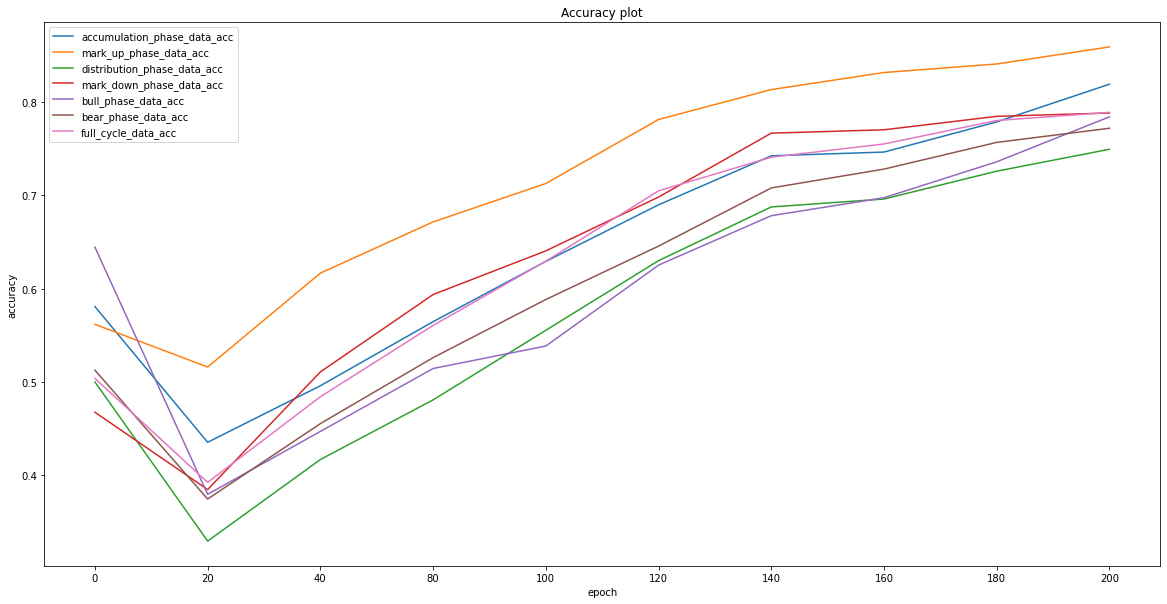

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

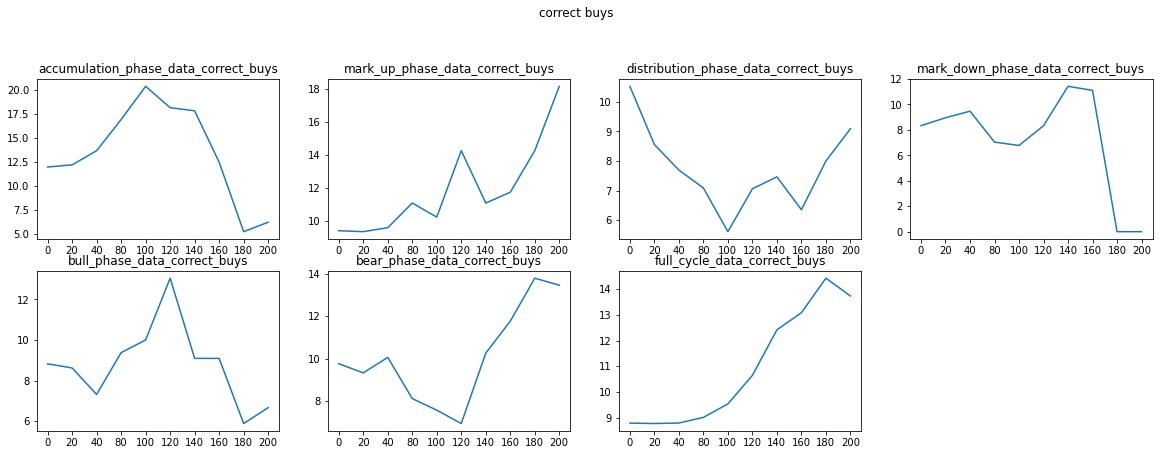

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

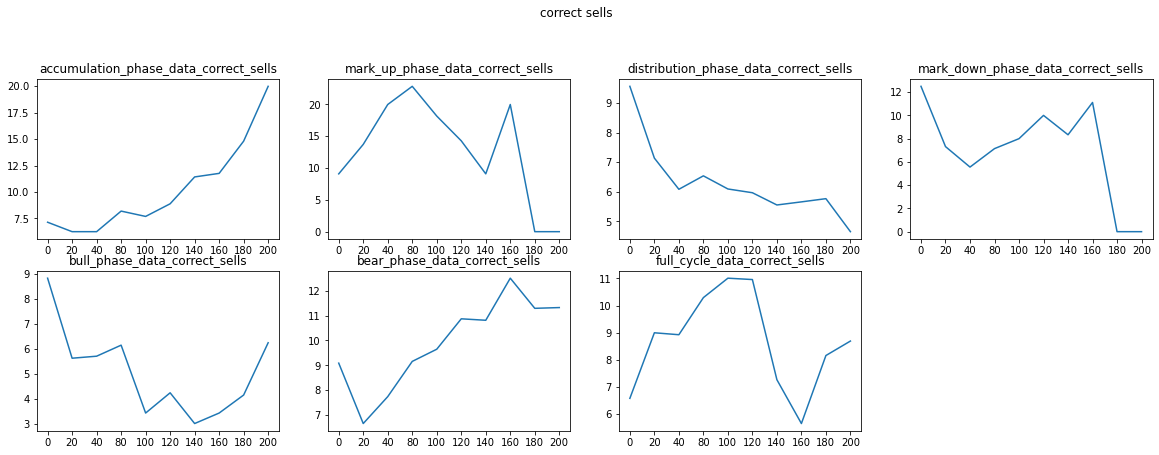

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

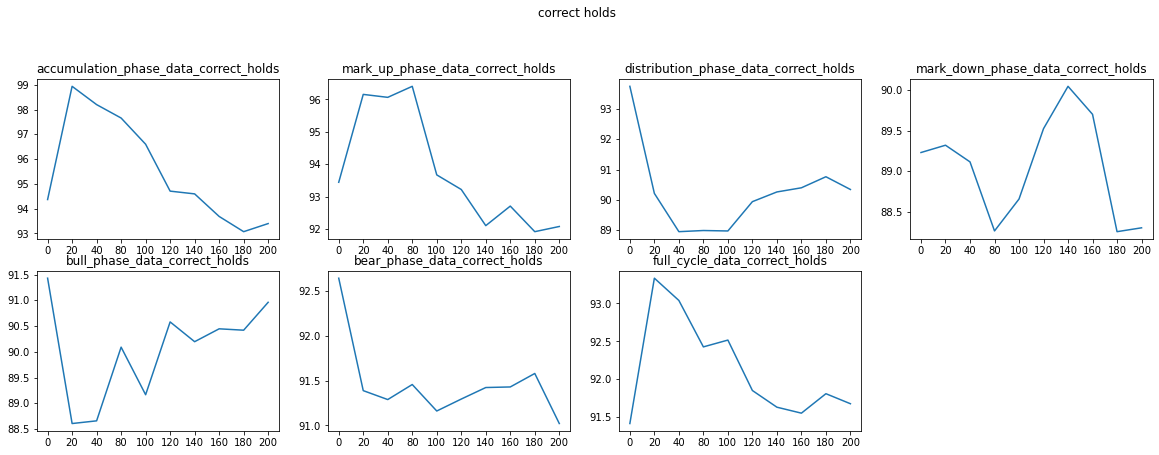

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

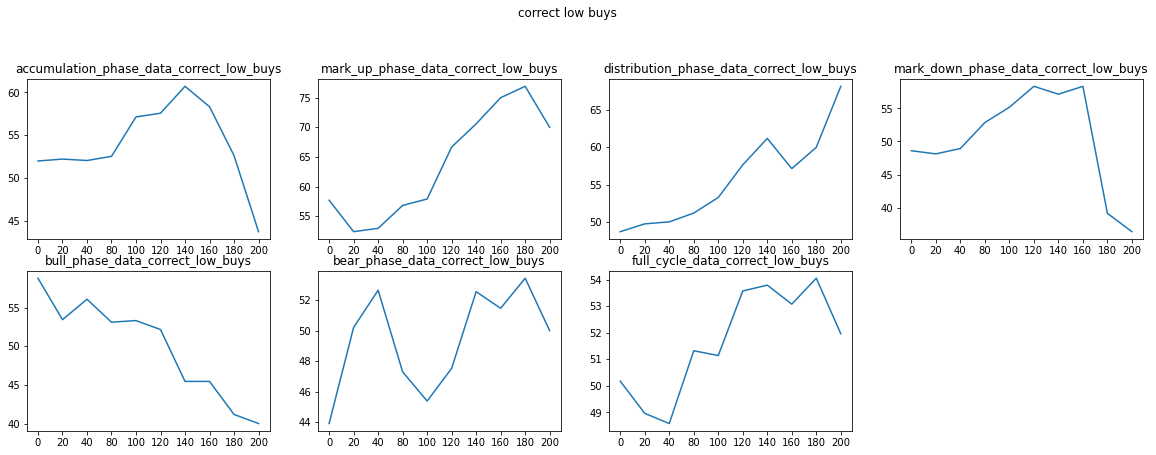

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

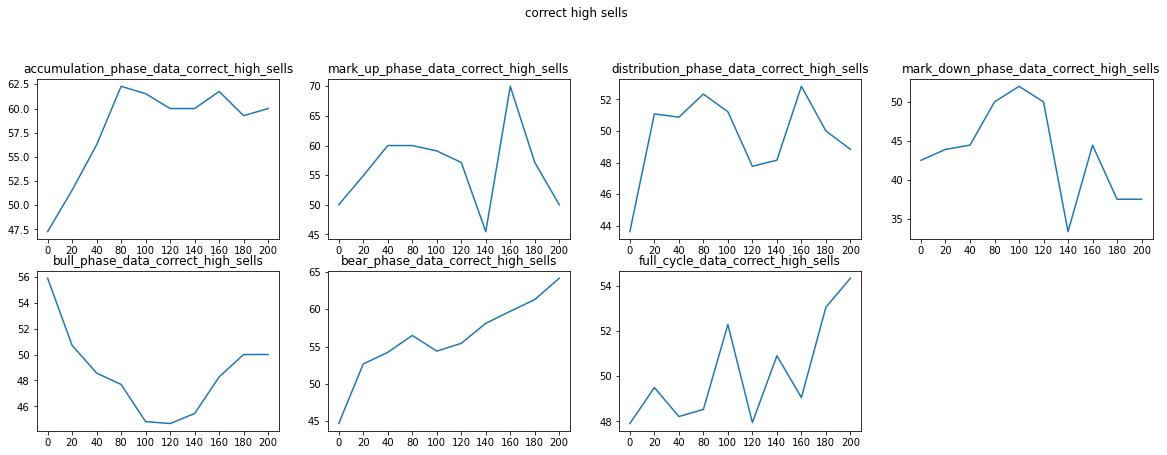

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

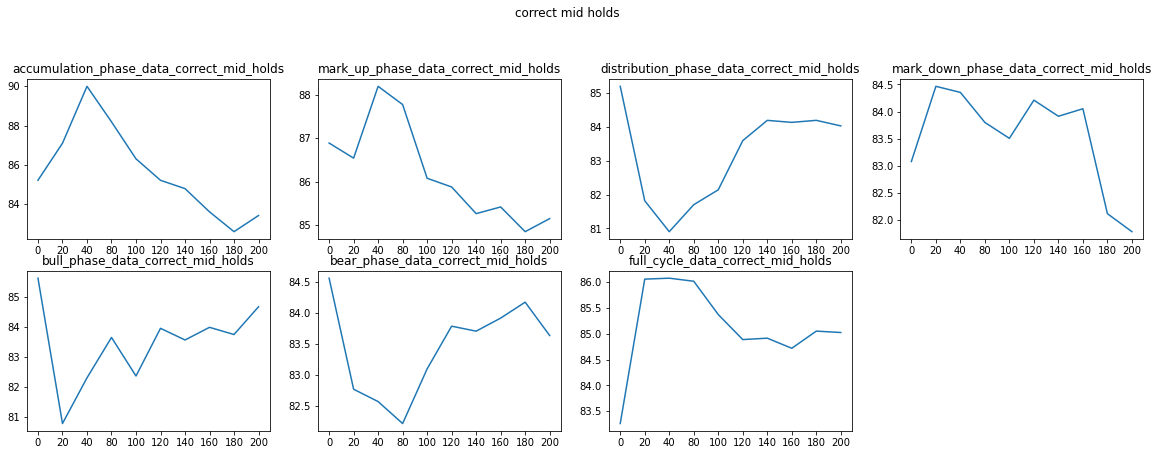

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

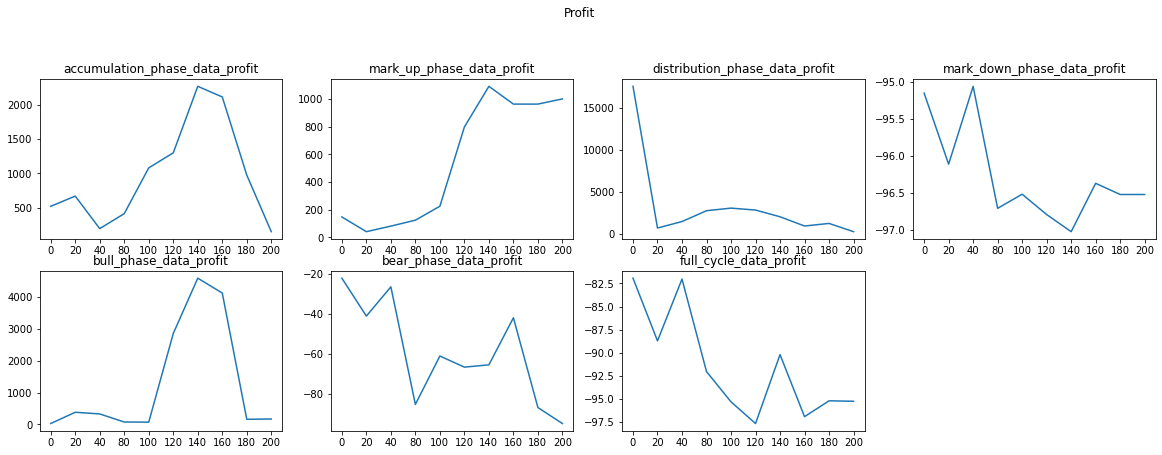

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")